<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/water_budget_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Figures from Mason Water Budget

By: Carli Beisel

Created on August, 2024

Purpose: Create figures for each reach.

In [36]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from scipy.stats import linregress

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ------------ #
# Custom Colors
# ------------ #

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Reach": "#C64846"
}

# for WB components
wb_palette = {
    'Qin': '#4BA3C3',     # Inflow
    'Precip (AF)': '#21A179',  # Precipitation
    'SR (AF)': '#D58936',      # SR
    'Qout': '#175676',    # Outflow
    'Evap (AF)': '#E46343',     # Evapotranspiration
    'Residual (AF)': 'none'    # Hollow for Residual
}


In [3]:
# ------------ #
# Custom Plot
# ------------ #

def theme_cust(ax):
    # Apply a classic style
    ax.set_facecolor('white')  # Panel background white
    ax.grid(visible=False)    # Turn off grid

    # Add a black border to the panel
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Customize axis text color
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    return ax

## Water Budget without Runoff

In [6]:
## ------------------------------ ##
##     IMPORT WATER BUDGET FILE   ##
## ------------------------------ ##

# Without Surface Runoff
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv') # no surface runoff

# With Surface Runoff
#file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_af.csv')
file['Month'] = pd.to_datetime(file['Month'], errors='coerce').dt.strftime('%B')


# Abbreviate month names
file['Month'] = file['Month'].map({
    'March': 'MAR', 'April': 'APR', 'May': 'MAY', 'June': 'JUN',
    'July': 'JUL', 'August': 'AUG', 'September': 'SEP', 'October': 'OCT',
    'November': 'NOV', 'December': 'DEC'
})

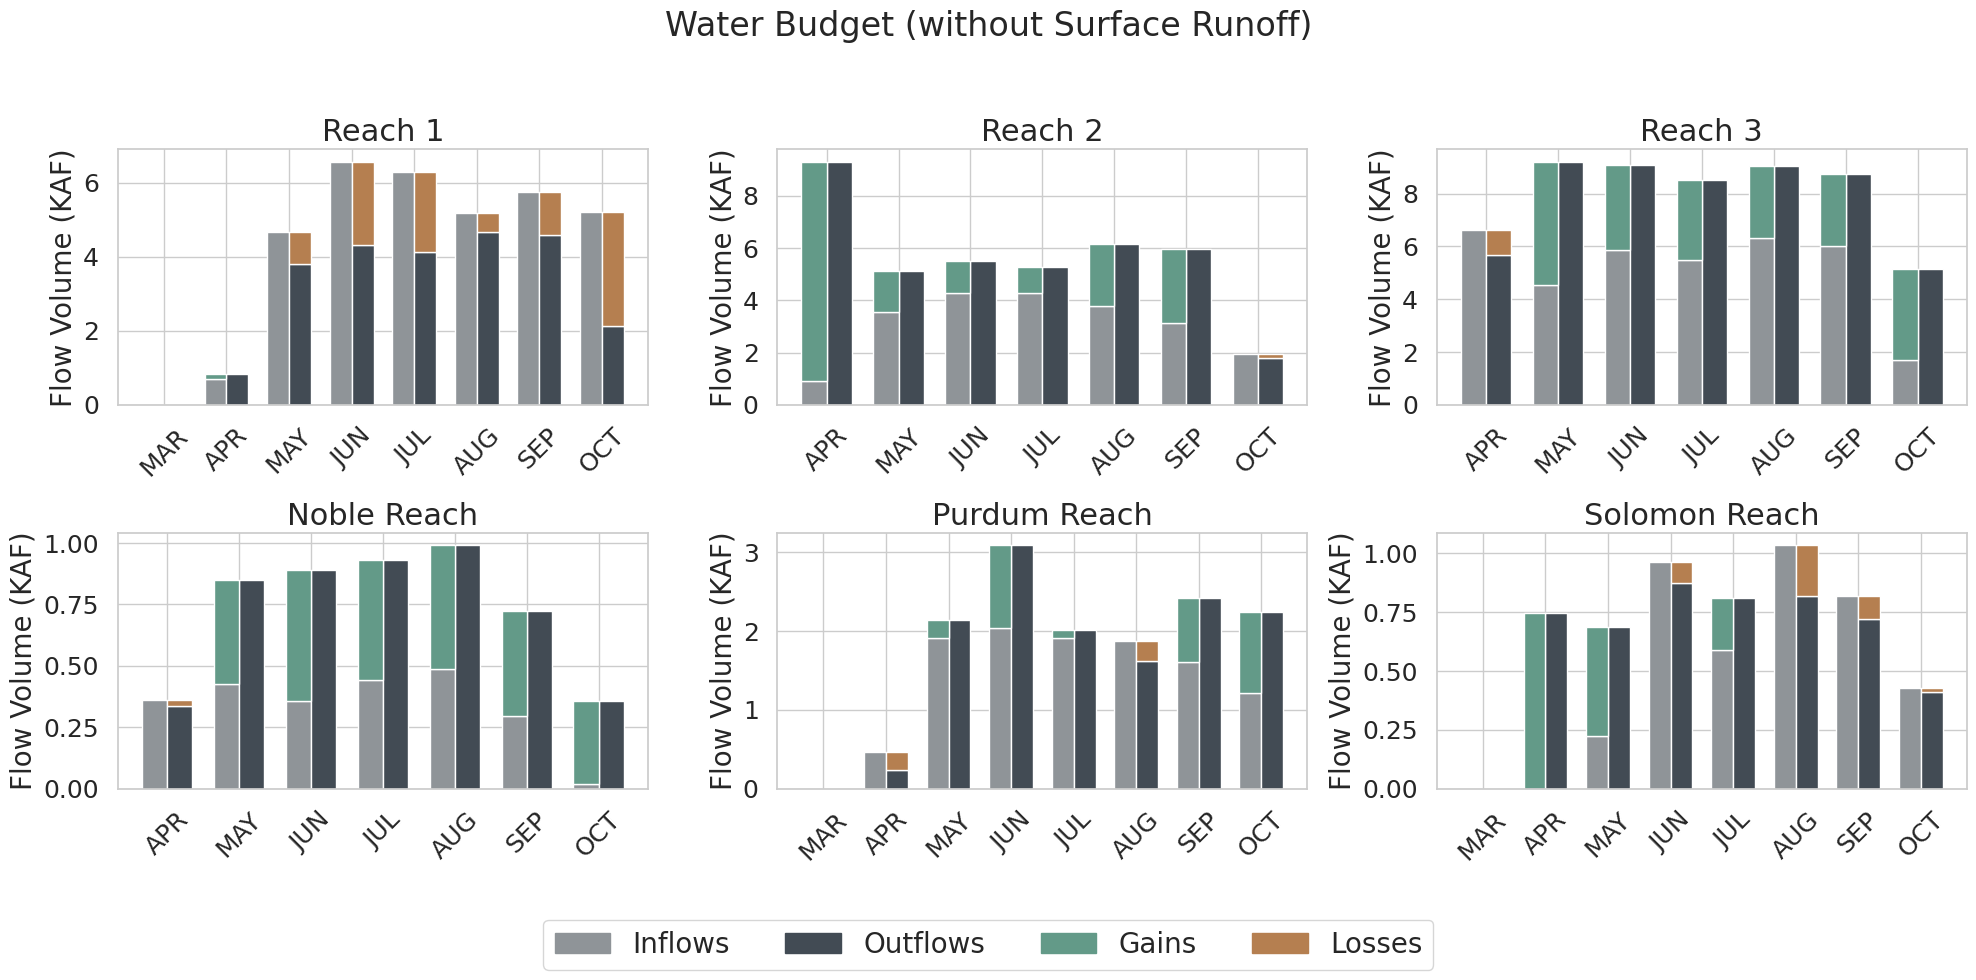

In [9]:
# --------------------- #
# Figure : Inflow/Outflow Comparison
# --------------------- #

# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#8F9498',          # Inflows
    'Outflows': '#424B54',        # Outflows
    'Residual Inflow': '#639A88',  # Residual on inflow side (positive)
    'Residual Outflow': '#B57F50'  # Residual on outflow side (negative)
}

# Data Preparation: Restructure the DataFrame
file['Inflows (KAF)'] = file[['Qin', 'Precip (AF)']].sum(axis=1) / 1000  # Convert to KAF
file['Outflows (KAF)'] = file[['Qout', 'Evap (AF)']].sum(axis=1) / 1000  # Convert to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000  # Convert residuals to KAF

# Ensure the month order and reach order are consistent
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Specify the desired order of reaches
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']

# Filter reaches based on the order and ensure all reaches are present in the dataset
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach and exclude NaN months
    reach_data = file[file['Reach'] == reach].dropna(subset=['Month']).sort_values(by='Month')

    # Skip if no data is available after filtering
    if reach_data.empty:
        continue

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.35  # Width of the bars

    # Plot inflows as positive bars
    ax.bar(
        x - width / 2, reach_data['Inflows (KAF)'], width, color=component_palette['Inflows']
    )

    # Plot outflows as positive bars
    ax.bar(
        x + width / 2, reach_data['Outflows (KAF)'], width, color=component_palette['Outflows']
    )

    # Plot residuals stacked on inflows or outflows
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow
            ax.bar(
                x[i] - width / 2, residual, width,
                bottom=reach_data['Inflows (KAF)'].iloc[i],
                color=component_palette['Residual Inflow']
            )
        elif residual < 0:  # Negative residual -> outflow
            ax.bar(
                x[i] + width / 2, abs(residual), width,
                bottom=reach_data['Outflows (KAF)'].iloc[i],
                color=component_palette['Residual Outflow']
            )

    # Formatting for each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, size=18)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (KAF)", fontsize=20)

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=component_palette['Inflows'], label='Inflows'),
    mpatches.Patch(color=component_palette['Outflows'], label='Outflows'),
    mpatches.Patch(color=component_palette['Residual Inflow'], label='Gains'),
    mpatches.Patch(color=component_palette['Residual Outflow'], label='Losses')
]

fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (without Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

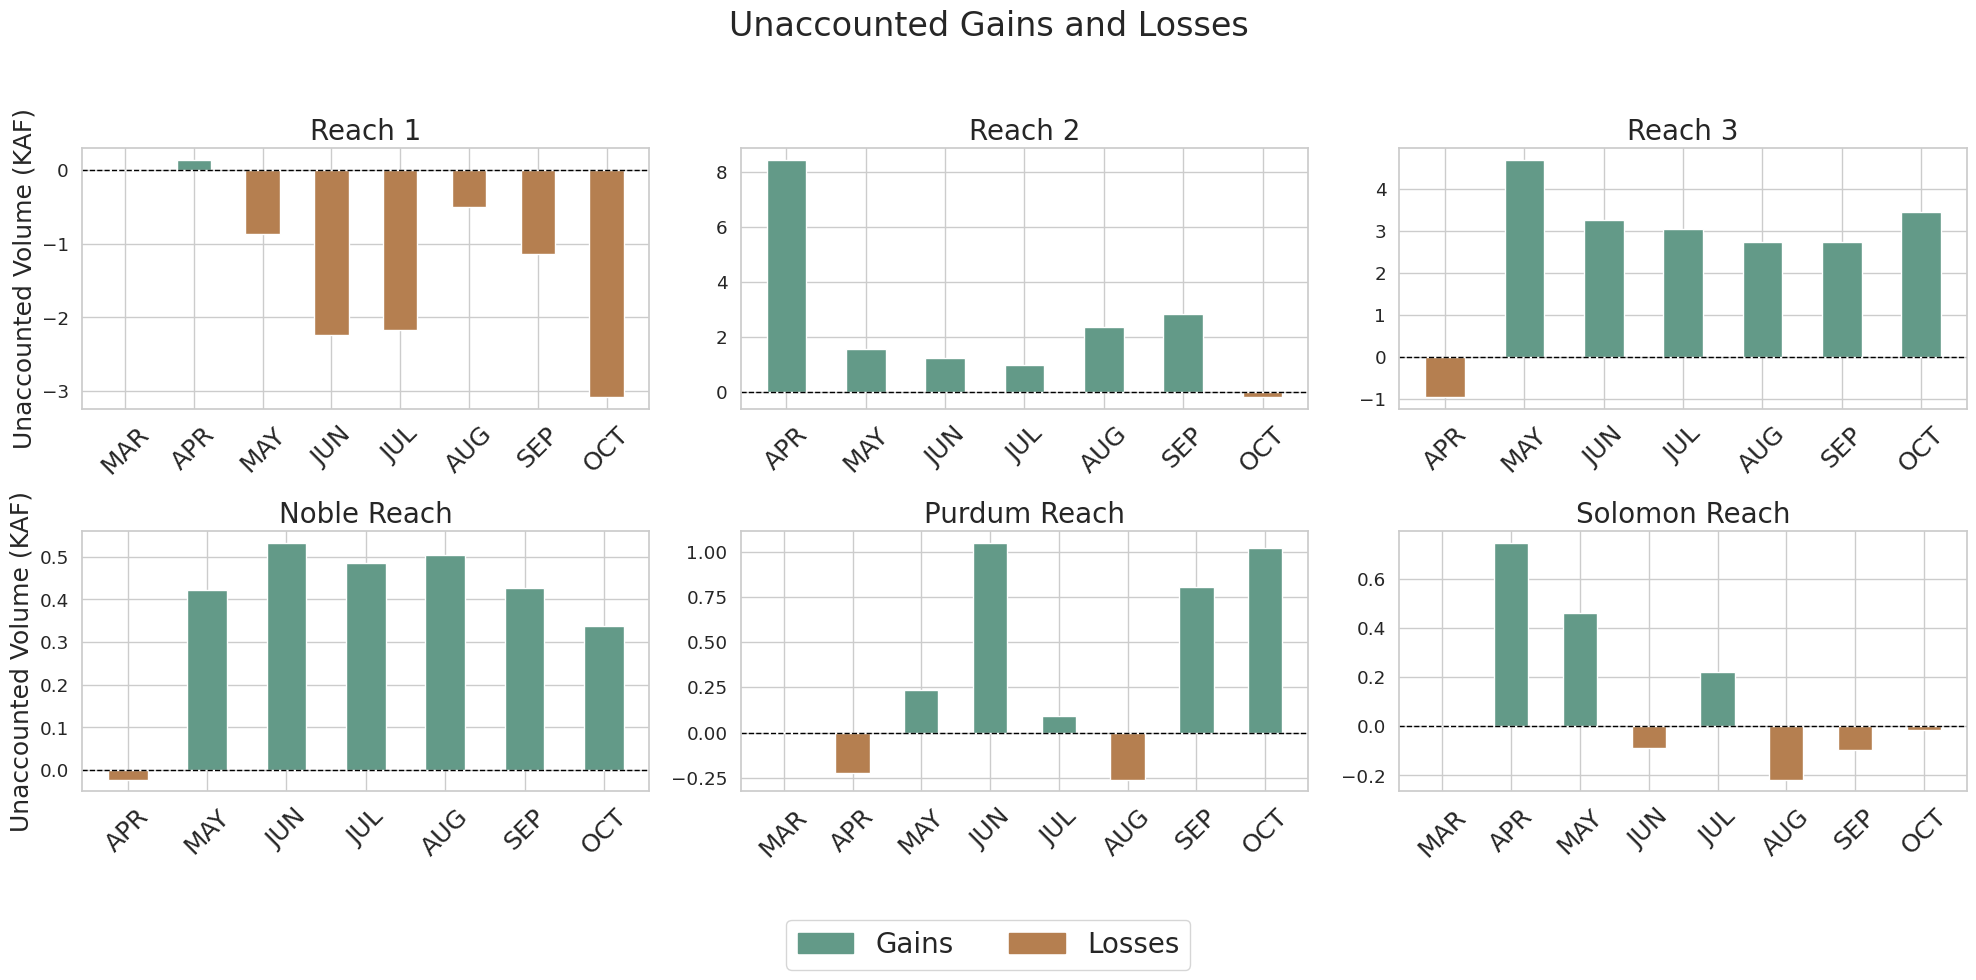

In [11]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #
# Define custom color palette for residuals
residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Filter and sort data for valid months
valid_months = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
file = file[file['Month'].isin(valid_months)]
file['Month'] = pd.Categorical(file['Month'], categories=valid_months, ordered=True)

# Specify the desired order of reaches
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']

# Filter reaches based on the order and ensure all reaches are present in the dataset
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (KAF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]

# Add the legend
fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Unaccounted Gains and Losses", fontsize=24)

# Adjust layout to fit the legend and title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

## Water Budget with Runoff data

In [12]:
## ------------------------------ ##
##     IMPORT WATER BUDGET FILE   ##
## ------------------------------ ##

# With Surface Runoff
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_af.csv')
file['Month'] = pd.to_datetime(file['Month'], errors='coerce').dt.strftime('%B')
file = file[file['Month'].isin(['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'])]


# Abbreviate month names
file['Month'] = file['Month'].map({
    'March': 'MAR', 'April': 'APR', 'May': 'MAY', 'June': 'JUN',
    'July': 'JUL', 'August': 'AUG', 'September': 'SEP', 'October': 'OCT',
    'November': 'NOV', 'December': 'DEC'
})

<ipython-input-12-a28e9504d0c9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Month'] = file['Month'].map({


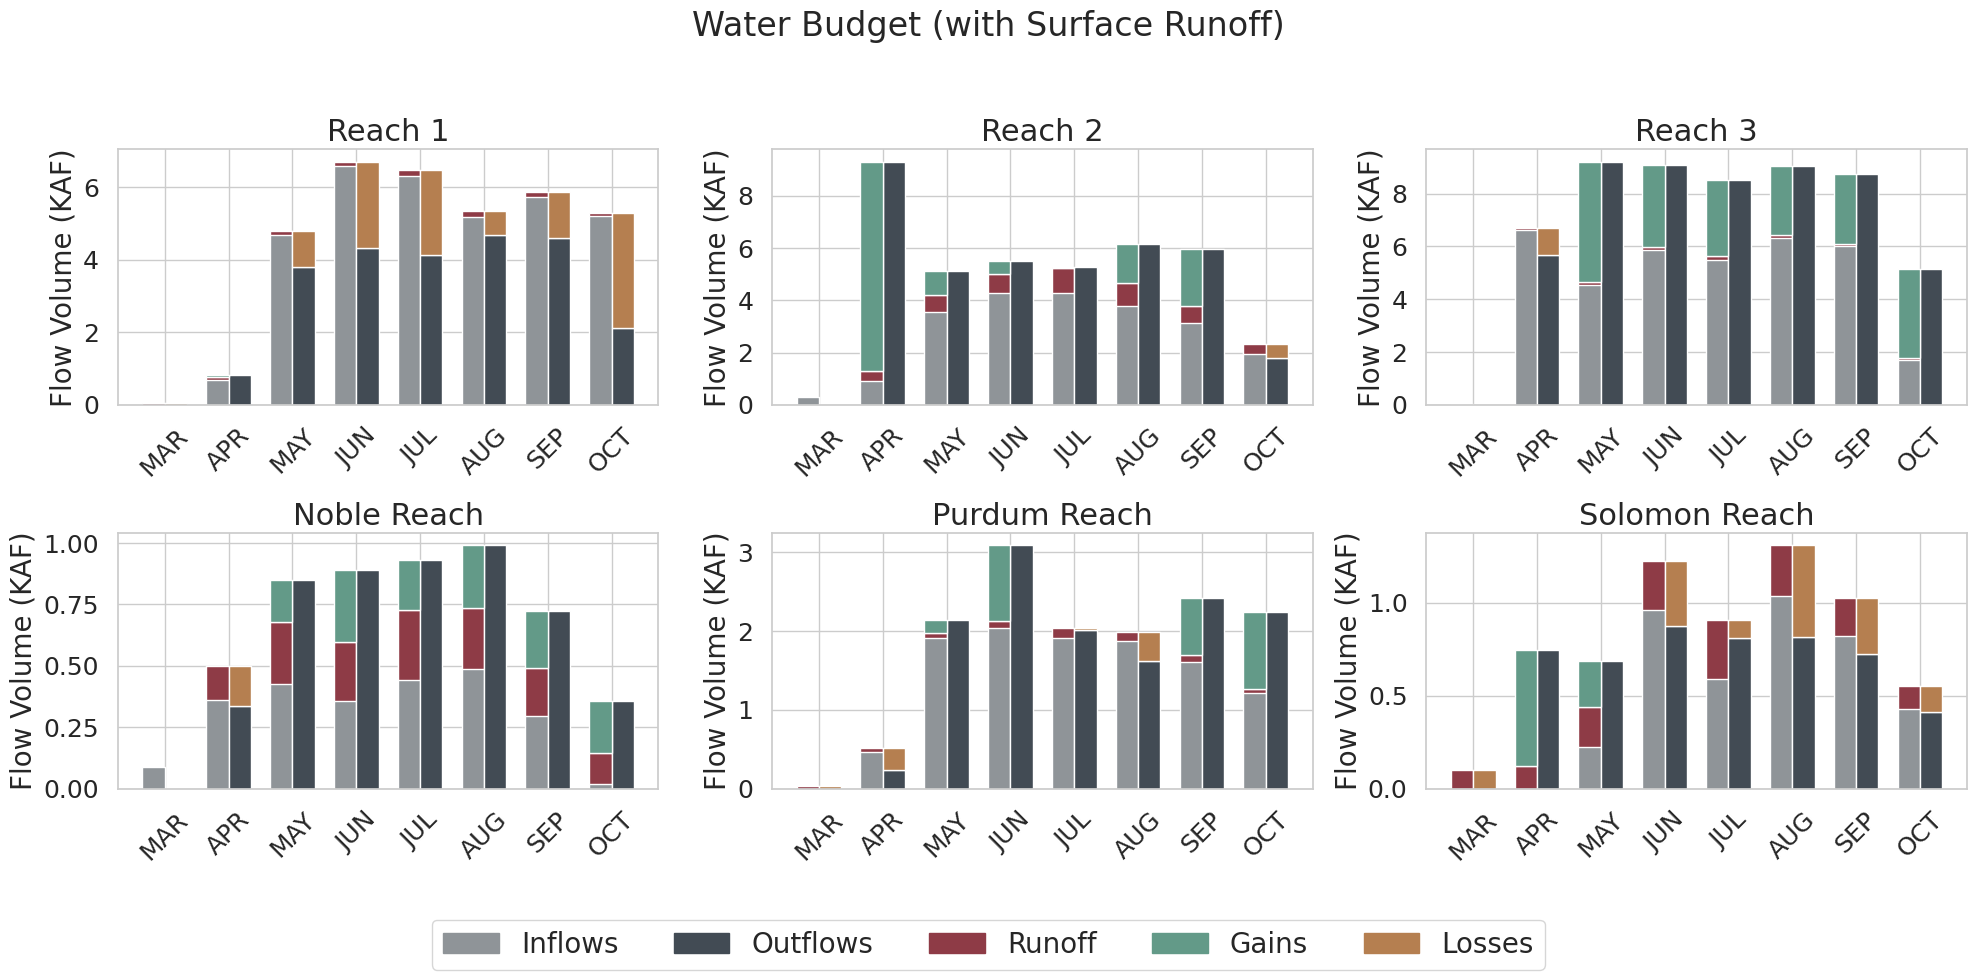

In [13]:
# --------------------- #
# Figure : Water Budget
# --------------------- #

# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#8F9498',          # Inflows
    'Outflows': '#424B54',        # Outflows
    'Residual Inflow': '#639A88',  # Residual on inflow side (positive)
    'Residual Outflow': '#B57F50', # Residual on outflow side (negative)
    'SR': '#8E3B46'               # SR component (Surface Runoff)
}


# Convert all flow values to KAF (thousands of acre-feet)
file['Inflows (KAF)'] = file[['Qin', 'Precip (AF)', 'SR (AF)']].sum(axis=1) / 1000
file['Outflows (KAF)'] = file[['Qout', 'Evap (AF)']].sum(axis=1) / 1000
file['Qin (KAF)'] = file['Qin'] / 1000
file['Precip (KAF)'] = file['Precip (AF)'] / 1000
file['SR (KAF)'] = file['SR (AF)'] / 1000
file['Qout (KAF)'] = file['Qout'] / 1000
file['Evap (KAF)'] = file['Evap (AF)'] / 1000
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Specify month and reach orders
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break

    ax = axes[idx]
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')
    x = np.arange(len(reach_data['Month']))
    width = 0.35

    # Plot inflows
    ax.bar(x - width / 2, reach_data['Inflows (KAF)'], width, color=component_palette['Inflows'])

    # Plot SR
    ax.bar(x - width / 2, reach_data['SR (KAF)'], width,
           bottom=reach_data['Qin (KAF)'] + reach_data['Precip (KAF)'],
           color=component_palette['SR'])

    # Plot outflows
    ax.bar(x + width / 2, reach_data['Outflows (KAF)'], width, color=component_palette['Outflows'])

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:
            ax.bar(x[i] - width / 2, residual, width,
                   bottom=reach_data['Inflows (KAF)'].iloc[i],
                   color=component_palette['Residual Inflow'])
        elif residual < 0:
            ax.bar(x[i] + width / 2, abs(residual), width,
                   bottom=reach_data['Outflows (KAF)'].iloc[i],
                   color=component_palette['Residual Outflow'])

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (KAF)", fontsize=20)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)

# Remove extra subplots
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=component_palette['Inflows'], label='Inflows'),
    mpatches.Patch(color=component_palette['Outflows'], label='Outflows'),
    mpatches.Patch(color=component_palette['SR'], label='Runoff'),
    mpatches.Patch(color=component_palette['Residual Inflow'], label='Gains'),
    mpatches.Patch(color=component_palette['Residual Outflow'], label='Losses')
]


fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (with Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

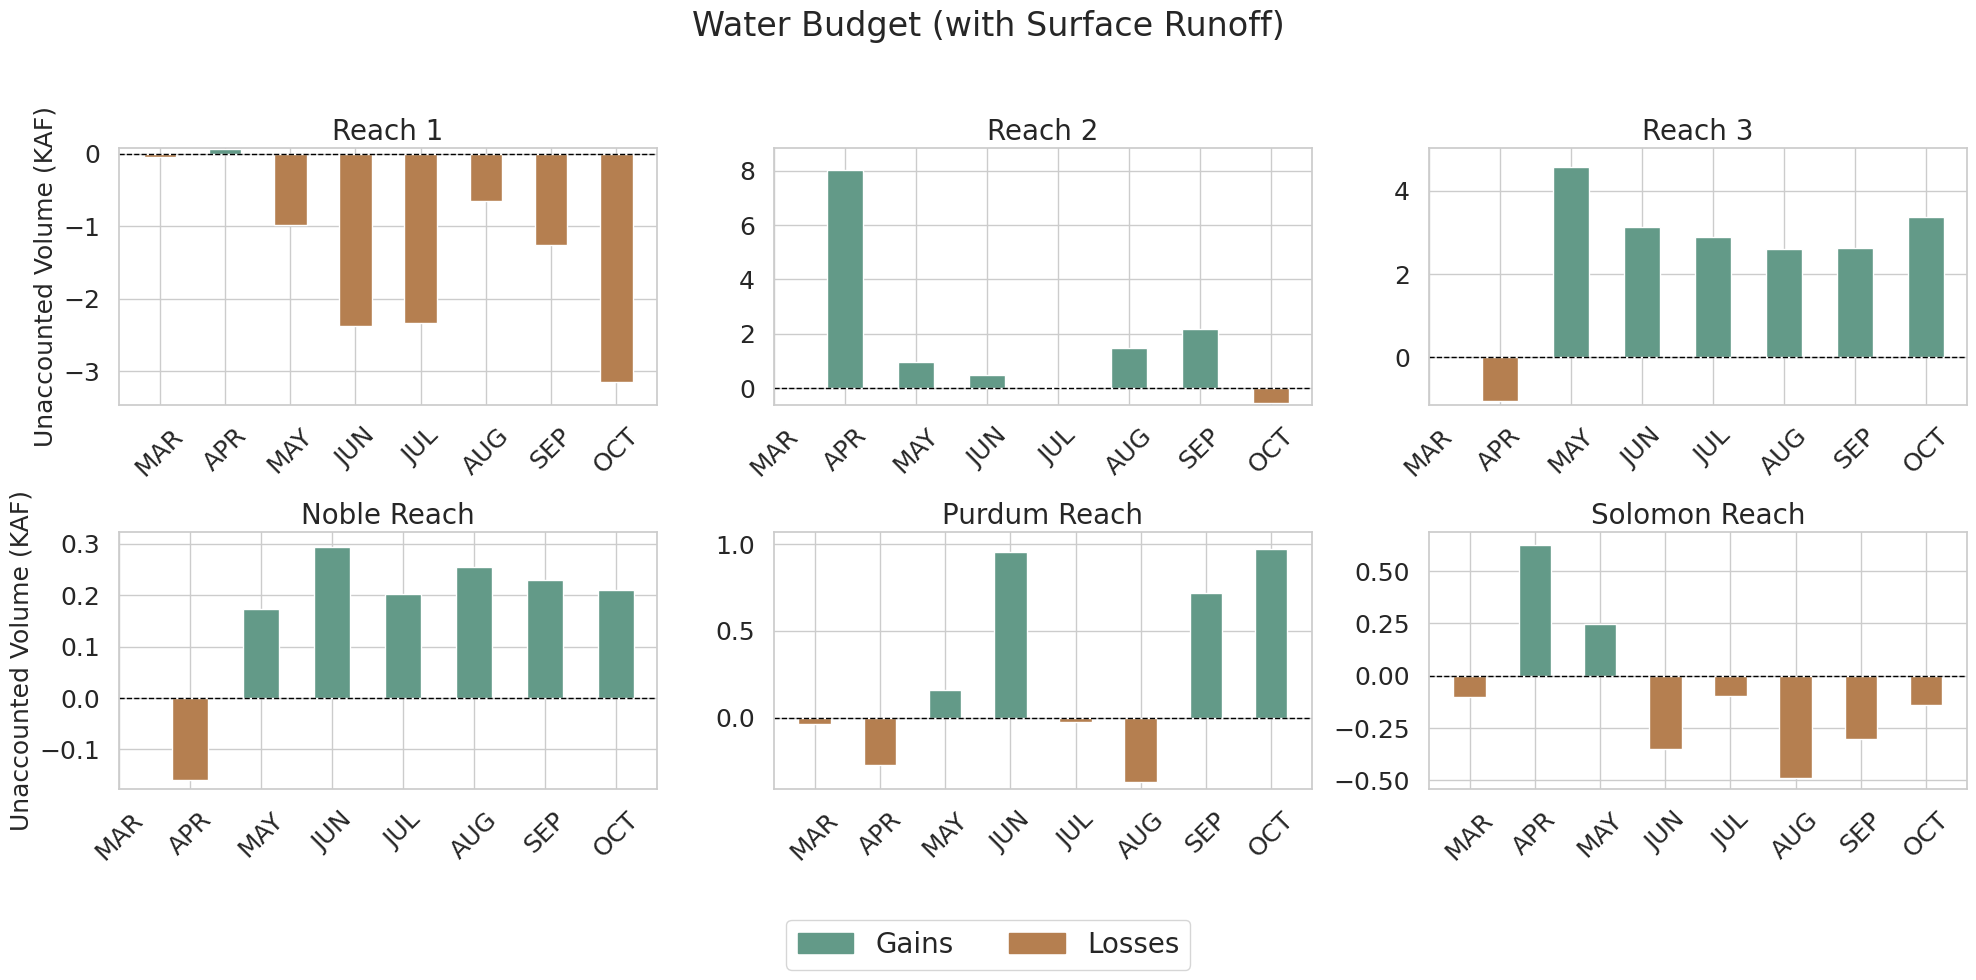

<Figure size 640x480 with 0 Axes>

In [14]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #

# Define custom color palette for residuals
residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Ensure the month order and reach order are consistent
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)

    # Set dynamic y-axis limits based on the reach data
    reach_min = reach_data['Residual (KAF)'].min()
    reach_max = reach_data['Residual (KAF)'].max()
    ax.set_ylim(reach_min - abs(reach_min) * 0.1, reach_max + abs(reach_max) * 0.1)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (KAF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]


fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (with Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

## Figure: Comparison of Water Budget Output to TFT Runoff & TVGWFM GW contribution

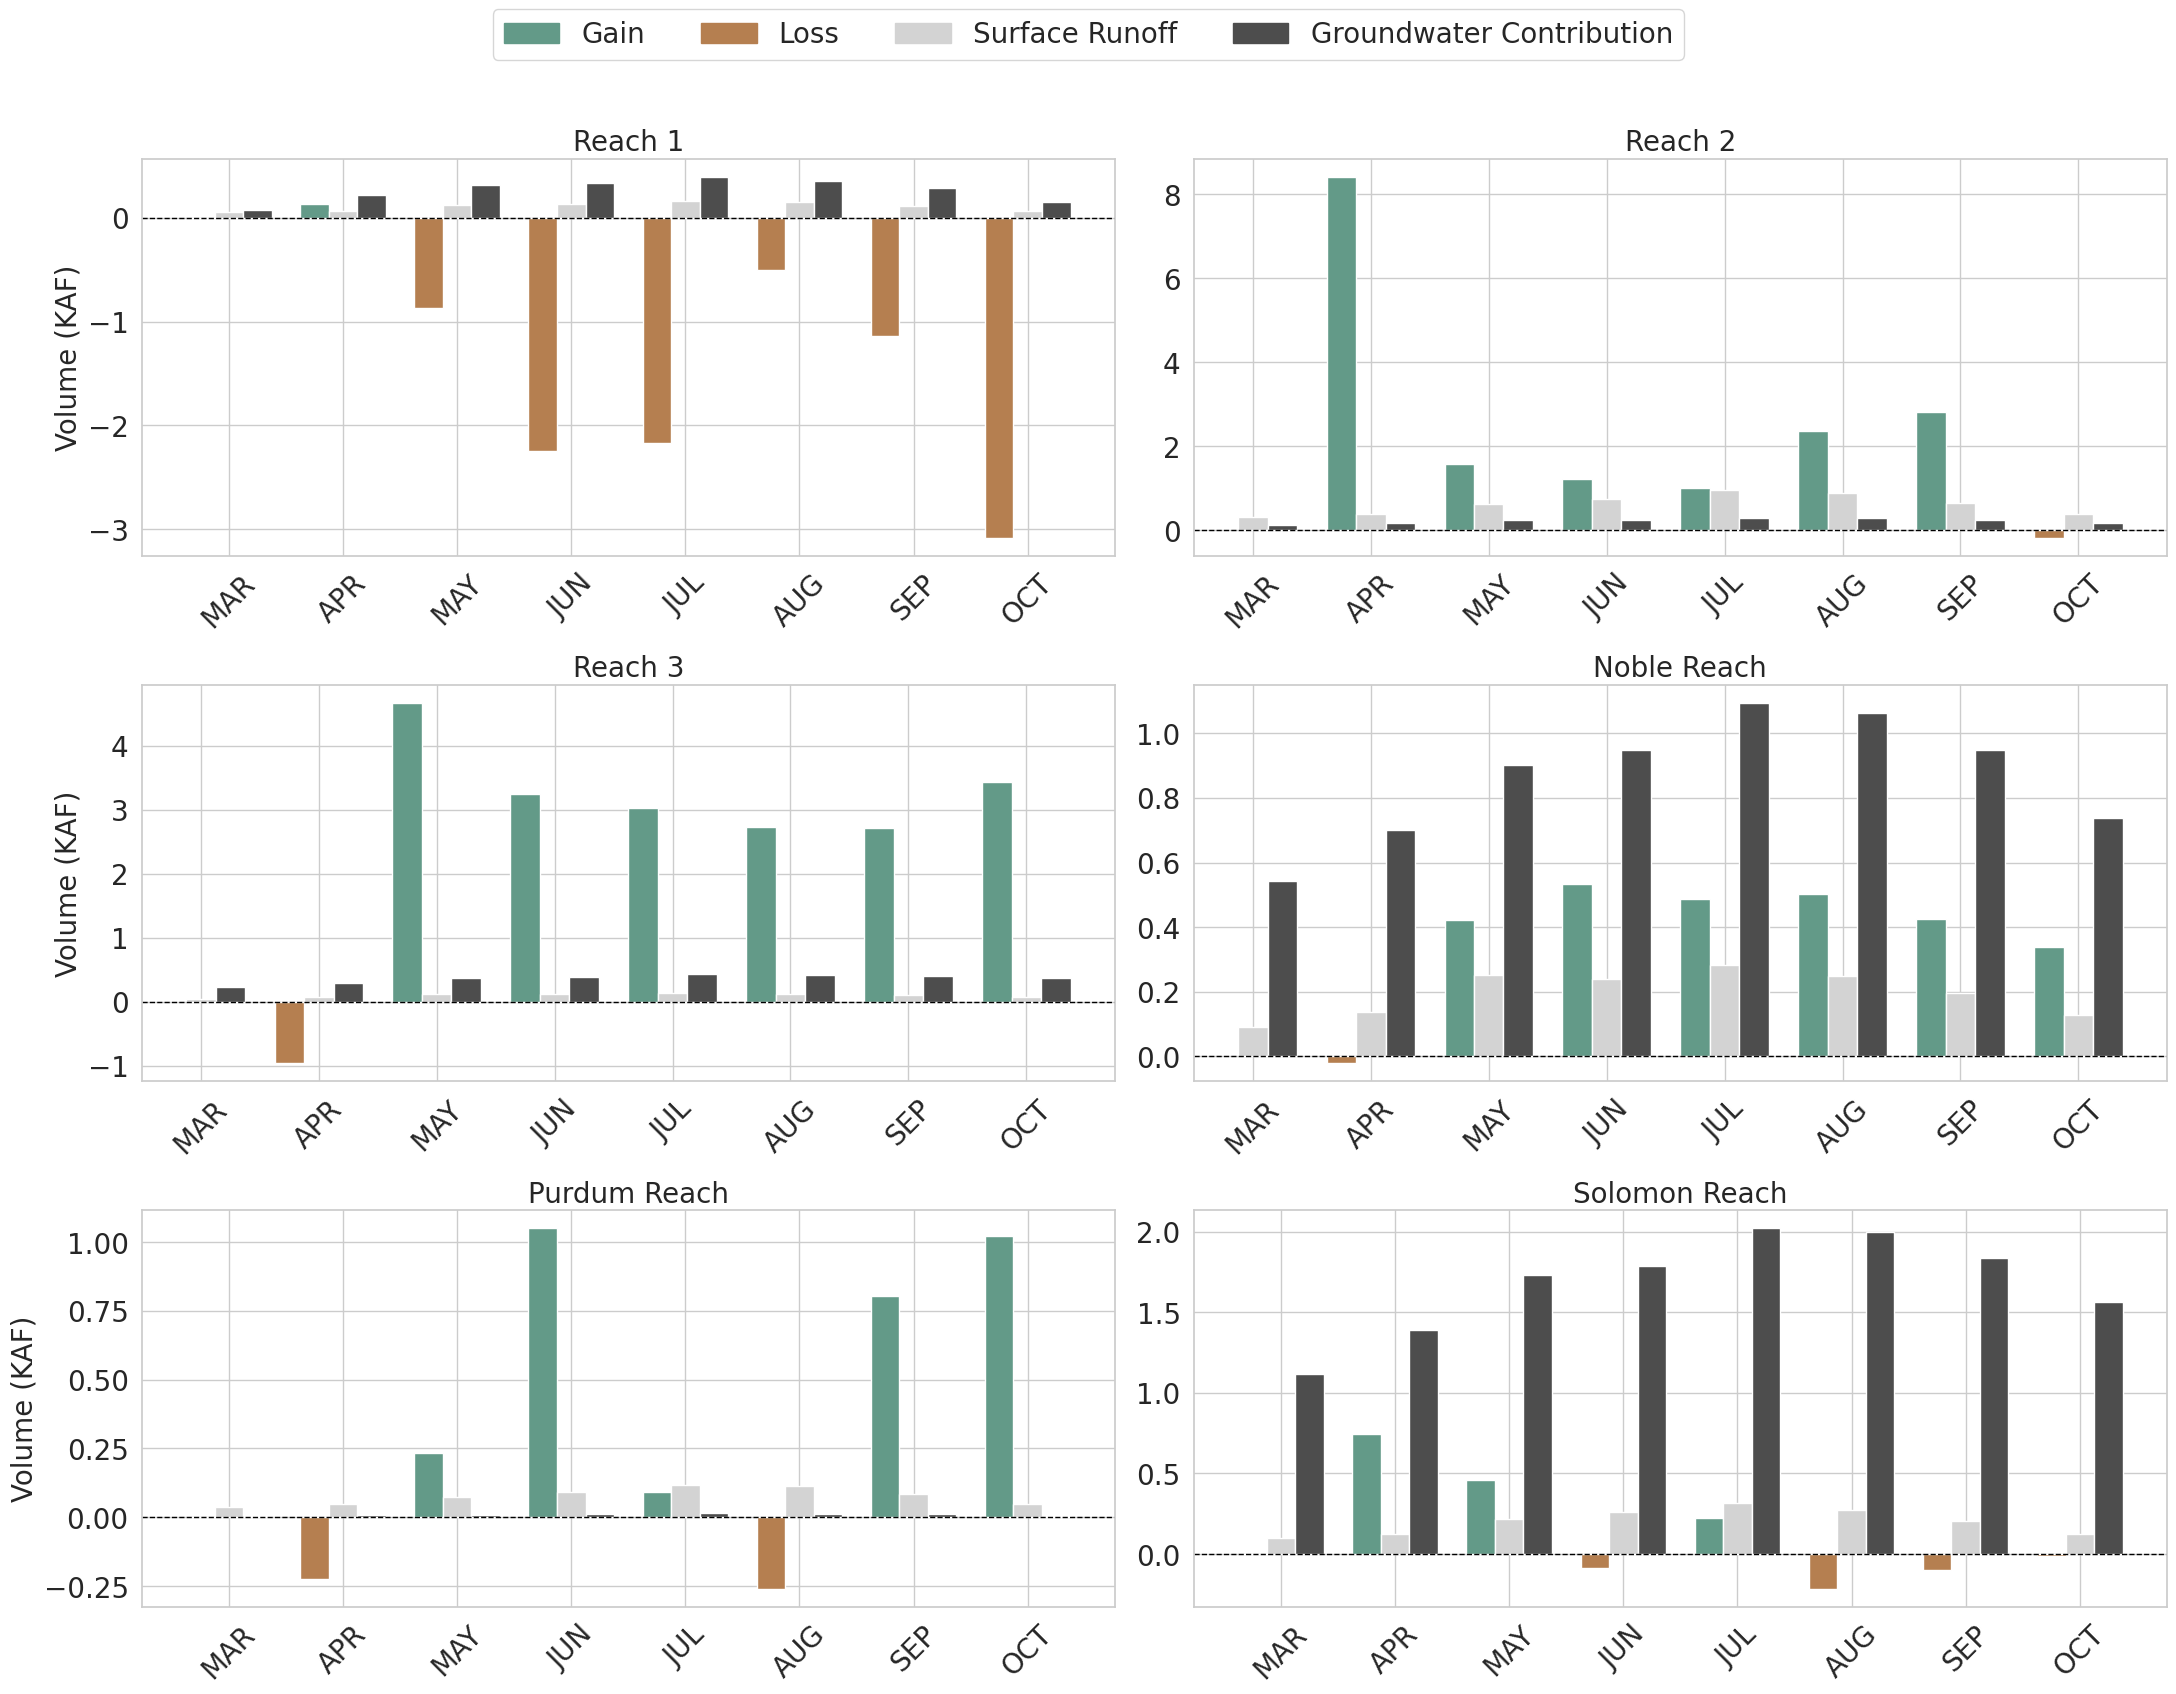

In [17]:
# Load the two files
file1 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget.csv')  # Contains SR (AF) and GW (AF)
file2 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv')  # Contains Residual (AF)

# Convert to KAF
file1['SR (KAF)'] = file1['SR (AF)'] / 1000
file1['GW (KAF)'] = -file1['GW (AF)'] / 1000  # Invert GW values
file2['Residual (KAF)'] = file2['Residual (AF)'] / 1000

# Filter and format months
valid_months = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
for df in [file1, file2]:
    df['Month'] = pd.to_datetime(df['Month'])
    df['Month'] = df['Month'].dt.strftime('%b').str.upper()
    df['Month'] = pd.Categorical(df['Month'], categories=valid_months, ordered=True)

file1 = file1[file1['Month'].isin(valid_months)]
file2 = file2[file2['Month'].isin(valid_months)]

# Standardize reach names
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
for df in [file1, file2]:
    df['Reach'] = df['Reach'].str.upper()
    df['Reach'] = pd.Categorical(df['Reach'], categories=[r.upper() for r in reach_order], ordered=True)

# Define color palette
palette = {
    'Residual Inflow': '#639A88',  # Positive residual (inflow)
    'Residual Outflow': '#B57F50',  # Negative residual (outflow)
    'SR': '#D3D3D3',  # Light grey for surface runoff
    'GW': '#4D4D4D'   # Dark grey for groundwater
}

# Set up the grid (2 columns, 3 rows)
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(22, 18))
axes = axes.flatten()

# Track labels to prevent duplicate legend entries
labels_added = {'Residual Inflow': False, 'Residual Outflow': False, 'SR': False, 'GW': False}

# Plot for each reach
for idx, reach in enumerate(reach_order):
    ax = axes[idx]
    residual_data = file2[file2['Reach'] == reach.upper()].sort_values(by='Month')
    sr_gw_data = file1[file1['Reach'] == reach.upper()].sort_values(by='Month')
    x = np.arange(len(valid_months))
    width = 0.25  # Bar width

    # Plot Residual (KAF)
    for i, residual in enumerate(residual_data['Residual (KAF)']):
        color = palette['Residual Inflow'] if residual > 0 else palette['Residual Outflow']
        label = 'Residual Inflow' if residual > 0 else 'Residual Outflow'
        ax.bar(x[i] - width, residual, width, color=color,
               label=label if not labels_added[label] else None)
        labels_added[label] = True

    # Plot SR (KAF)
    ax.bar(x, sr_gw_data['SR (KAF)'], width, color=palette['SR'], label='SR (KAF)' if not labels_added['SR'] else None)
    labels_added['SR'] = True

    # Plot GW (KAF) (inverted values)
    ax.bar(x + width, sr_gw_data['GW (KAF)'], width, color=palette['GW'], label='GW (KAF, inverted)' if not labels_added['GW'] else None)
    labels_added['GW'] = True

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(valid_months, rotation=45, fontsize=20)
    ax.set_title(f"{reach}", fontsize=20)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.tick_params(axis='y', labelsize=20)

    if idx % cols == 0:
        ax.set_ylabel("Volume (KAF)", fontsize=20)

# Remove unused axes
for idx in range(len(reach_order), len(axes)):
    fig.delaxes(axes[idx])

# Define legend handles
legend_handles = [
    mpatches.Patch(color=palette['Residual Inflow'], label='Gain'),
    mpatches.Patch(color=palette['Residual Outflow'], label='Loss'),
    mpatches.Patch(color=palette['SR'], label='Surface Runoff'),
    mpatches.Patch(color=palette['GW'], label='Groundwater Contribution')
]

# Add legend and title
fig.legend(handles=legend_handles, loc='upper center', ncol=4, fontsize=20, bbox_to_anchor=(0.5, 0.95))
fig.suptitle("", fontsize=24)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

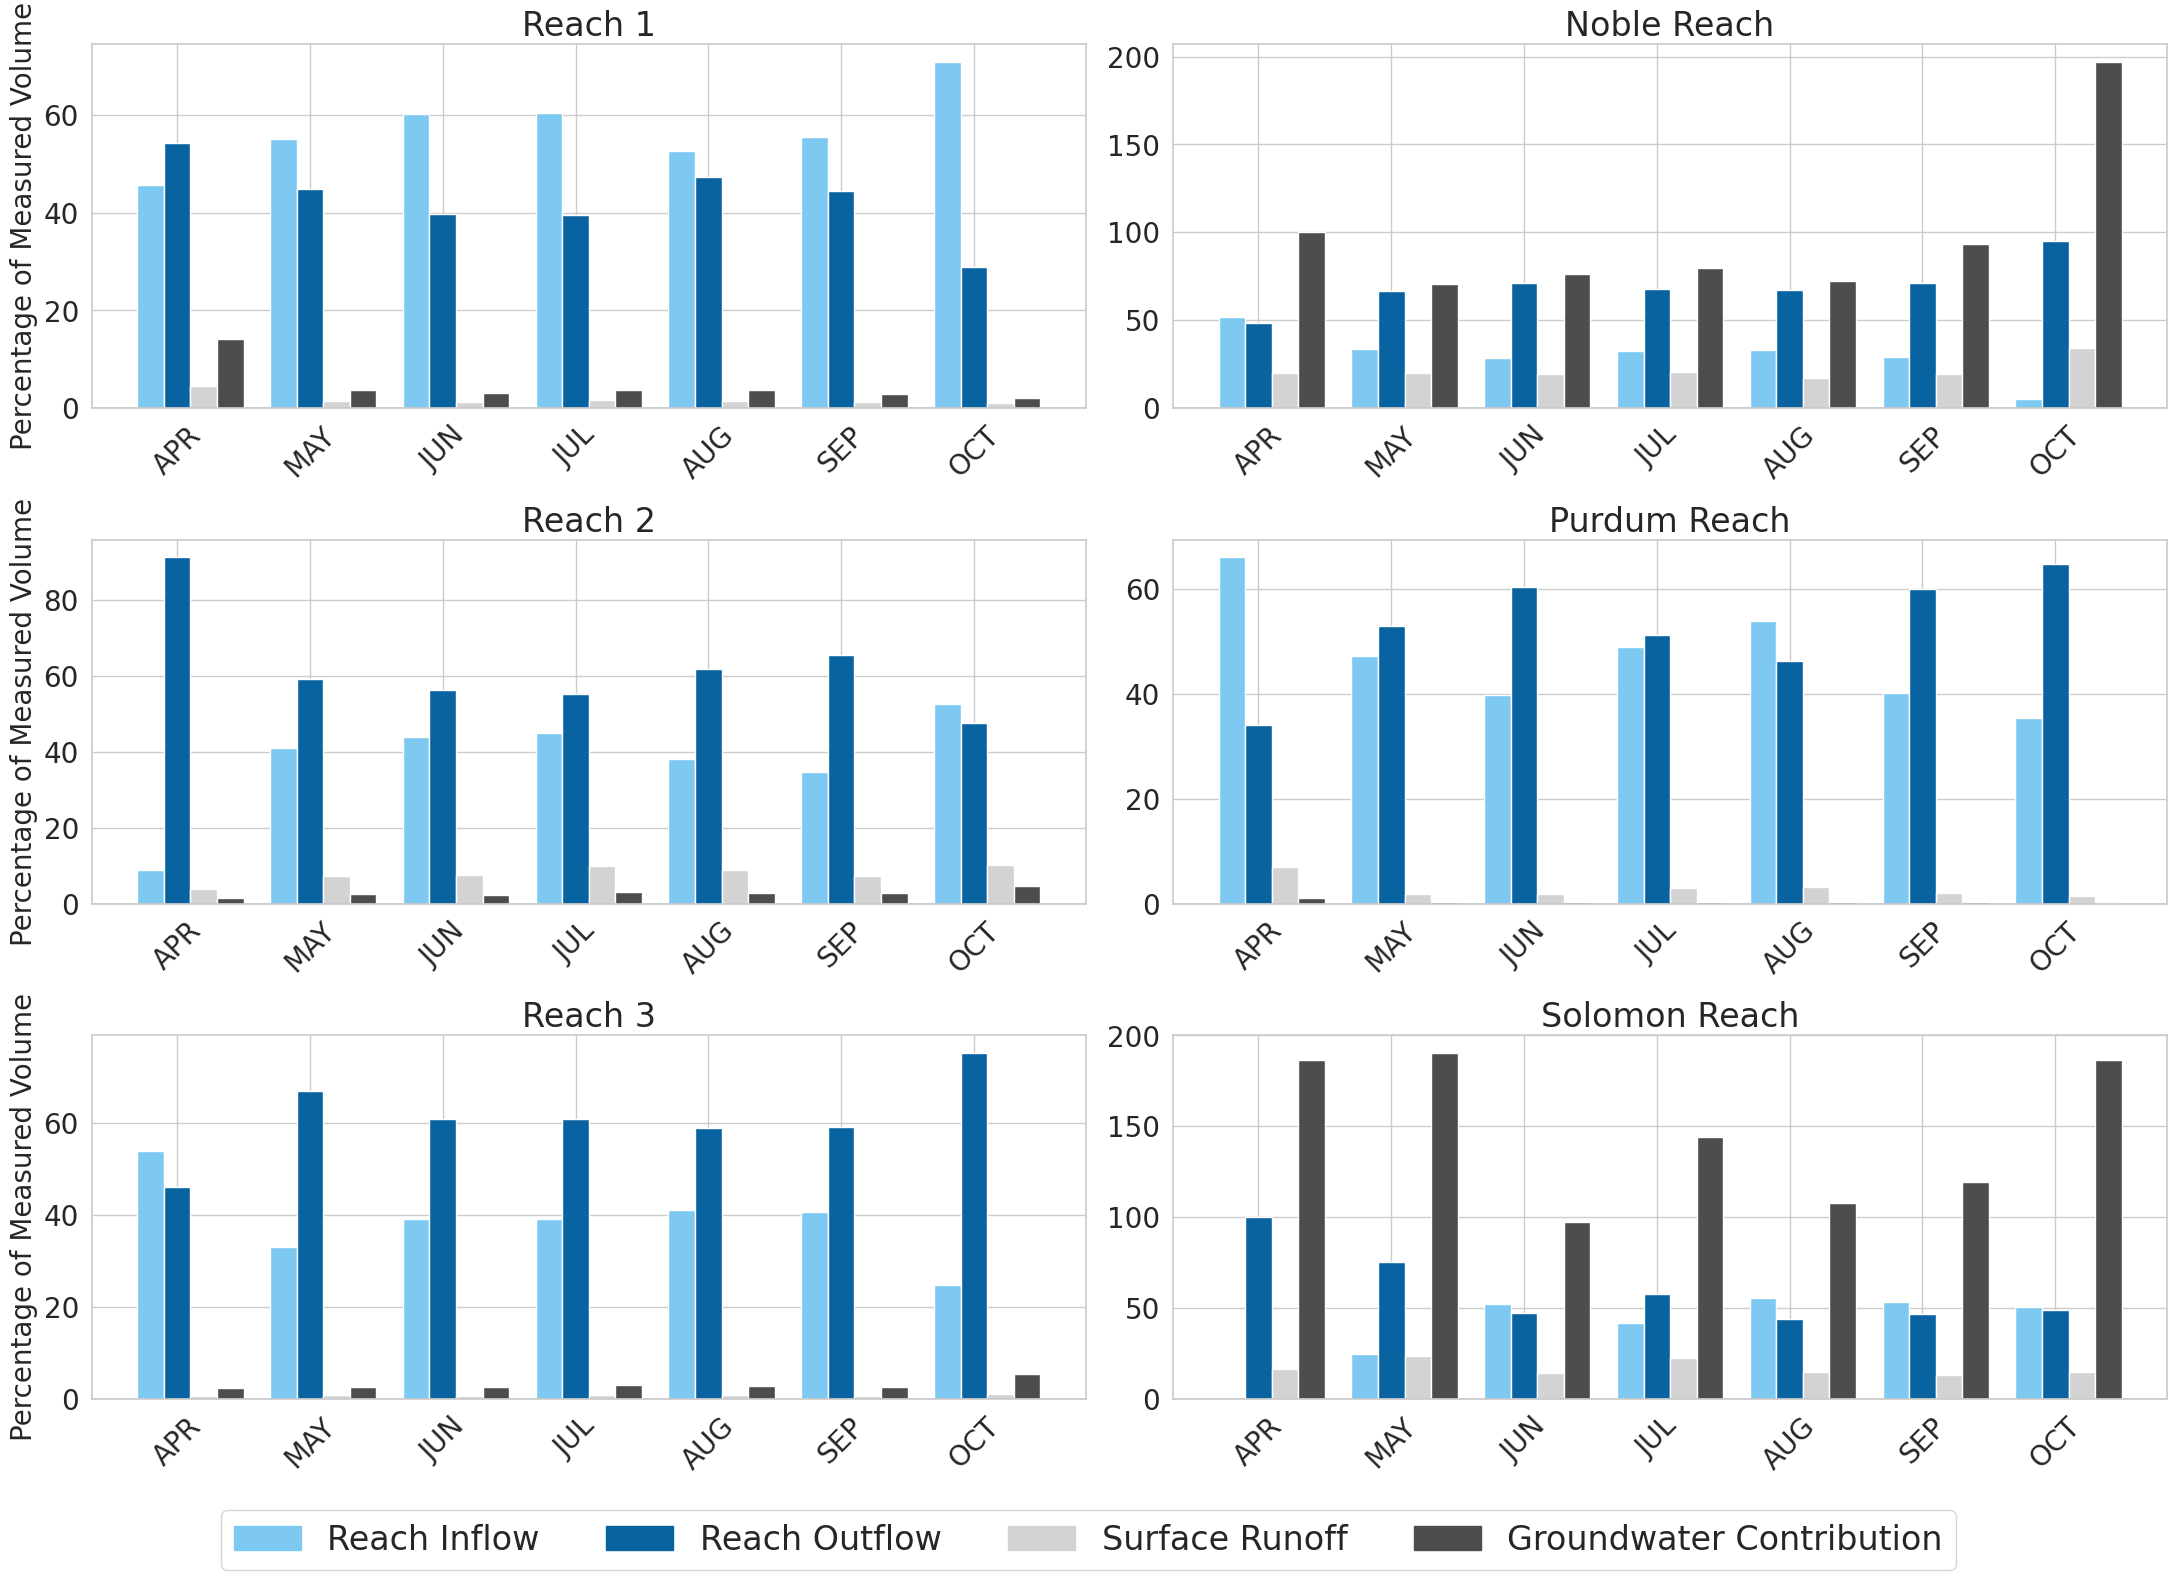

In [28]:
# ---------- #
# NORMALIZED
# ---------- #

# inflow and outflow compared with SW + GW

file1 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget.csv')  # Contains SR (AF) and GW (AF)
file2 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv')  # Contains Qin (AF) and Qout (AF)

# Convert to KAF
file1['SR (KAF)'] = file1['SR (AF)'] / 1000
file1['GW (KAF)'] = -file1['GW (AF)'] / 1000  # Invert GW values
file2['Qin (KAF)'] = file2['Qin (AF)'] / 1000
file2['Qout (KAF)'] = file2['Qout (AF)'] / 1000

# Calculate total flow (Qin + Qout) for normalization
file2['Total Flow (KAF)'] = file2['Qin (KAF)'] + file2['Qout (KAF)']

# Normalize all components and convert to percentage
file2['Qin (%)'] = (file2['Qin (KAF)'] / file2['Total Flow (KAF)']) * 100
file2['Qout (%)'] = (file2['Qout (KAF)'] / file2['Total Flow (KAF)']) * 100
file1['SR (%)'] = (file1['SR (KAF)'] / file2['Total Flow (KAF)']) * 100
file1['GW (%)'] = (file1['GW (KAF)'] / file2['Total Flow (KAF)']) * 100

# Filter and format months
valid_months = ['APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
for df in [file1, file2]:
    df['Month'] = pd.to_datetime(df['Month'])
    df['Month'] = df['Month'].dt.strftime('%b').str.upper()
    df['Month'] = pd.Categorical(df['Month'], categories=valid_months, ordered=True)

file1 = file1[file1['Month'].isin(valid_months)]
file2 = file2[file2['Month'].isin(valid_months)]

# Standardize reach names
reach_order = ['Reach 1', 'Noble Reach','Reach 2', 'Purdum Reach', 'Reach 3','Solomon Reach']
for df in [file1, file2]:
    df['Reach'] = df['Reach'].str.upper()
    df['Reach'] = pd.Categorical(df['Reach'], categories=[r.upper() for r in reach_order], ordered=True)

# Define color palette
palette = {
    'Qin': '#7EC9F1',
    'Qout': '#0863A0',
    'SR': '#D3D3D3',  # Light grey for surface runoff
    'GW': '#4D4D4D'   # Dark grey for groundwater
}

# Set up the grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(22, 18))
axes = axes.flatten()

# Track labels to prevent duplicate legend entries
labels_added = {'Qin': False, 'Qout': False, 'SR': False, 'GW': False}

# Plot for each reach
for idx, reach in enumerate(reach_order):
    ax = axes[idx]
    inflow_outflow_data = file2[file2['Reach'] == reach.upper()].sort_values(by='Month')
    sr_gw_data = file1[file1['Reach'] == reach.upper()].sort_values(by='Month')
    x = np.arange(len(valid_months))
    width = 0.2  # Bar width

    # Plot Qin (%)
    ax.bar(x - width, inflow_outflow_data['Qin (%)'], width, color=palette['Qin'],
           label='Qin (%)' if not labels_added['Qin'] else None)
    labels_added['Qin'] = True

    # Plot Qout (%)
    ax.bar(x, inflow_outflow_data['Qout (%)'], width, color=palette['Qout'],
           label='Qout (%)' if not labels_added['Qout'] else None)
    labels_added['Qout'] = True

    # Plot SR (%)
    ax.bar(x + width, sr_gw_data['SR (%)'], width, color=palette['SR'],
           label='SR (%)' if not labels_added['SR'] else None)
    labels_added['SR'] = True

    # Plot GW (%)
    ax.bar(x + 2 * width, sr_gw_data['GW (%)'], width, color=palette['GW'],
           label='GW (%)' if not labels_added['GW'] else None)
    labels_added['GW'] = True

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(valid_months, rotation=45, fontsize=20)
    ax.set_title(f"{reach}", fontsize=24)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.tick_params(axis='y', labelsize=20)

    if idx % cols == 0:
        ax.set_ylabel("Percentage of Measured Volume", fontsize=20)

# Remove unused axes
for idx in range(len(reach_order), len(axes)):
    fig.delaxes(axes[idx])

# Define legend handles
legend_handles = [
    mpatches.Patch(color=palette['Qin'], label='Reach Inflow'),
    mpatches.Patch(color=palette['Qout'], label='Reach Outflow'),
    mpatches.Patch(color=palette['SR'], label='Surface Runoff'),
    mpatches.Patch(color=palette['GW'], label='Groundwater Contribution')
]

# Add legend below the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=24, bbox_to_anchor=(0.5, -0.05))
fig.suptitle("", fontsize=24)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

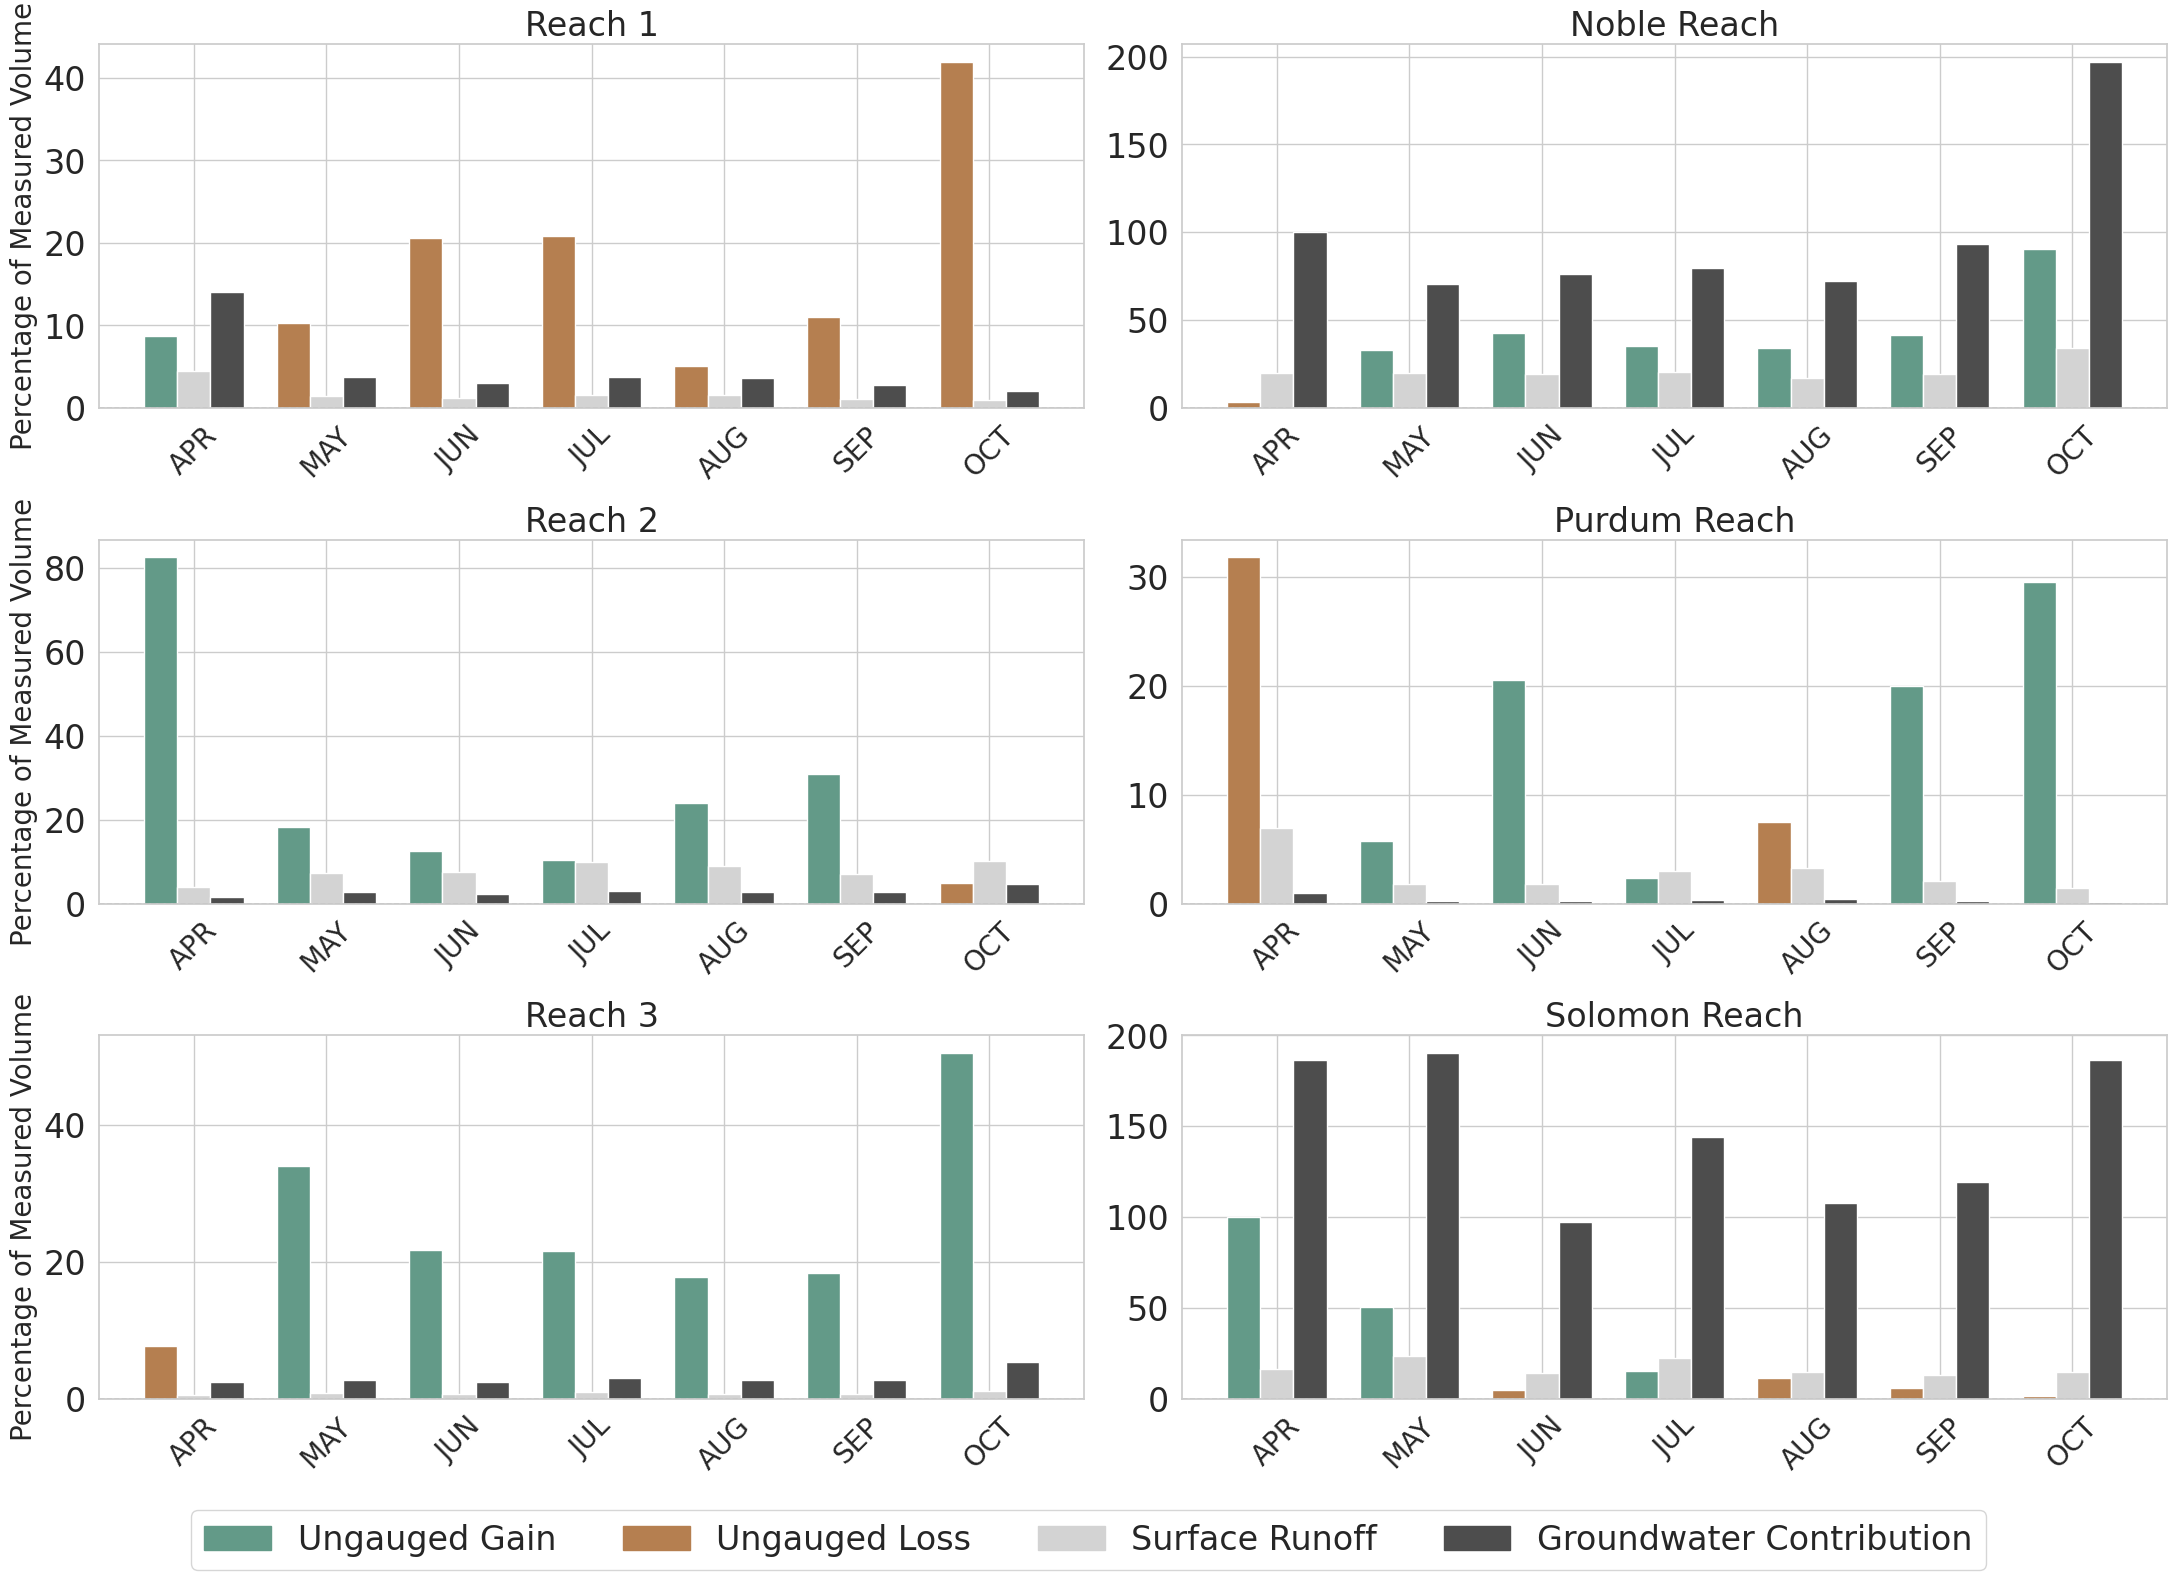

In [30]:
# ---------- #
# NORMALIZED
# ---------- #

# Residual compared with SW + GW
# inflow and outflow compared with SW + GW

file1 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget.csv')  # Contains SR (AF) and GW (AF)
file2 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv')  # Contains Qin (AF) and Qout (AF)

# Convert to KAF
file1['SR (KAF)'] = file1['SR (AF)'] / 1000
file1['GW (KAF)'] = -file1['GW (AF)'] / 1000  # Invert GW values
file2['Qin (KAF)'] = file2['Qin (AF)'] / 1000
file2['Qout (KAF)'] = file2['Qout (AF)'] / 1000

# Calculate total flow (Qin + Qout) for normalization
file2['Total Flow (KAF)'] = file2['Qin (KAF)'] + file2['Qout (KAF)']

# Convert to KAF
file1['SR (KAF)'] = file1['SR (AF)'] / 1000
file1['GW (KAF)'] = -file1['GW (AF)'] / 1000  # Invert GW values
file2['Residual (KAF)'] = np.abs(file2['Residual (AF)']) / 1000  # Take absolute values for positive percentages

# Normalize all components and convert to percentage
file1['SR (%)'] = (file1['SR (KAF)'] / file2['Total Flow (KAF)']) * 100
file1['GW (%)'] = (file1['GW (KAF)'] / file2['Total Flow (KAF)']) * 100
file2['Residual (%)'] = (file2['Residual (KAF)'] / file2['Total Flow (KAF)']) * 100

# Filter and format months (April to October only)
valid_months = ['APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
for df in [file1, file2]:
    df['Month'] = pd.to_datetime(df['Month'])
    df['Month'] = df['Month'].dt.strftime('%b').str.upper()
    df['Month'] = pd.Categorical(df['Month'], categories=valid_months, ordered=True)

file1 = file1[file1['Month'].isin(valid_months)]
file2 = file2[file2['Month'].isin(valid_months)]

# Standardize reach names
reach_order = ['Reach 1', 'Noble Reach', 'Reach 2', 'Purdum Reach', 'Reach 3', 'Solomon Reach']
for df in [file1, file2]:
    df['Reach'] = df['Reach'].str.upper()
    df['Reach'] = pd.Categorical(df['Reach'], categories=[r.upper() for r in reach_order], ordered=True)

# Define color palette
palette = {
    'Positive Residual': '#639A88',  # Green for positive residual
    'Negative Residual': '#B57F50',  # Brown for negative residual
    'SR': '#D3D3D3',                # Light grey for surface runoff
    'GW': '#4D4D4D'                 # Dark grey for groundwater
}

# Set up the grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(22, 18))
axes = axes.flatten()

# Track labels to prevent duplicate legend entries
labels_added = {'Positive Residual': False, 'Negative Residual': False, 'SR': False, 'GW': False}

# Plot for each reach
for idx, reach in enumerate(reach_order):
    ax = axes[idx]
    residual_data = file2[file2['Reach'] == reach.upper()].sort_values(by='Month')
    sr_gw_data = file1[file1['Reach'] == reach.upper()].sort_values(by='Month')
    x = np.arange(len(valid_months))
    width = 0.25  # Bar width

    # Plot Residual (%)
    for i, residual in enumerate(residual_data['Residual (%)']):
        is_positive = file2[file2['Reach'] == reach.upper()]['Residual (AF)'].iloc[i] > 0
        color = palette['Positive Residual'] if is_positive else palette['Negative Residual']
        label = 'Positive Residual' if is_positive else 'Negative Residual'
        ax.bar(x[i] - width, residual, width, color=color,
               label=label if not labels_added[label] else None)
        labels_added[label] = True

    # Plot SR (%)
    ax.bar(x, sr_gw_data['SR (%)'], width, color=palette['SR'],
           label='SR (%)' if not labels_added['SR'] else None)
    labels_added['SR'] = True

    # Plot GW (%)
    ax.bar(x + width, sr_gw_data['GW (%)'], width, color=palette['GW'],
           label='GW (%)' if not labels_added['GW'] else None)
    labels_added['GW'] = True

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(valid_months, rotation=45, fontsize=20)
    ax.set_title(f"{reach}", fontsize=24)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.tick_params(axis='y', labelsize=24)

    if idx % cols == 0:
        ax.set_ylabel("Percentage of Measured Volume", fontsize=20)

# Remove unused axes
for idx in range(len(reach_order), len(axes)):
    fig.delaxes(axes[idx])

# Define legend handles
legend_handles = [
    mpatches.Patch(color=palette['Positive Residual'], label='Ungauged Gain'),
    mpatches.Patch(color=palette['Negative Residual'], label='Ungauged Loss'),
    mpatches.Patch(color=palette['SR'], label='Surface Runoff'),
    mpatches.Patch(color=palette['GW'], label='Groundwater Contribution')
]

# Add legend below the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=24, bbox_to_anchor=(0.5, -0.05))
fig.suptitle("", fontsize=24)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

## Regression Plot of Urban Area X Runoff (normalized by dividing runoff / reach area)

In [34]:
# ------------ #
# Compile Data
# ------------ #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
reaches = reaches.to_crs(epsg=5070)
reaches['area_m2'] = reaches.geometry.area
reaches['area_mi2'] = reaches['area_m2'] / 2_589_988.11  # Conversion to square miles
reach_area = reaches[['Reach', 'area_mi2']]

# Load urban area data
urban = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv')
urban_area = urban[['Reach', 'Urban Land Cover Area (mi²)']]

# Merge reach area and urban area data
merged = pd.merge(reach_area, urban_area, on='Reach', how='left')

# Calculate urban percentage
merged['Urban Percent'] = (merged['Urban Land Cover Area (mi²)'] / merged['area_mi2']) * 100

# Load irrigation runoff data
runoff = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_runoff_final.csv')

# Calculate total runoff for each reach as a DataFrame
total_runoff = runoff.groupby('Reach', as_index=False)['runoff(af)'].sum()
total_runoff.rename(columns={'runoff(af)': 'total_runoff(af)'}, inplace=True)

# Merge total runoff with the merged DataFrame
final_merged = pd.merge(merged, total_runoff, on='Reach', how='left')
final_merged['normalized_runoff(af)'] = final_merged['total_runoff(af)'] / final_merged['area_mi2']

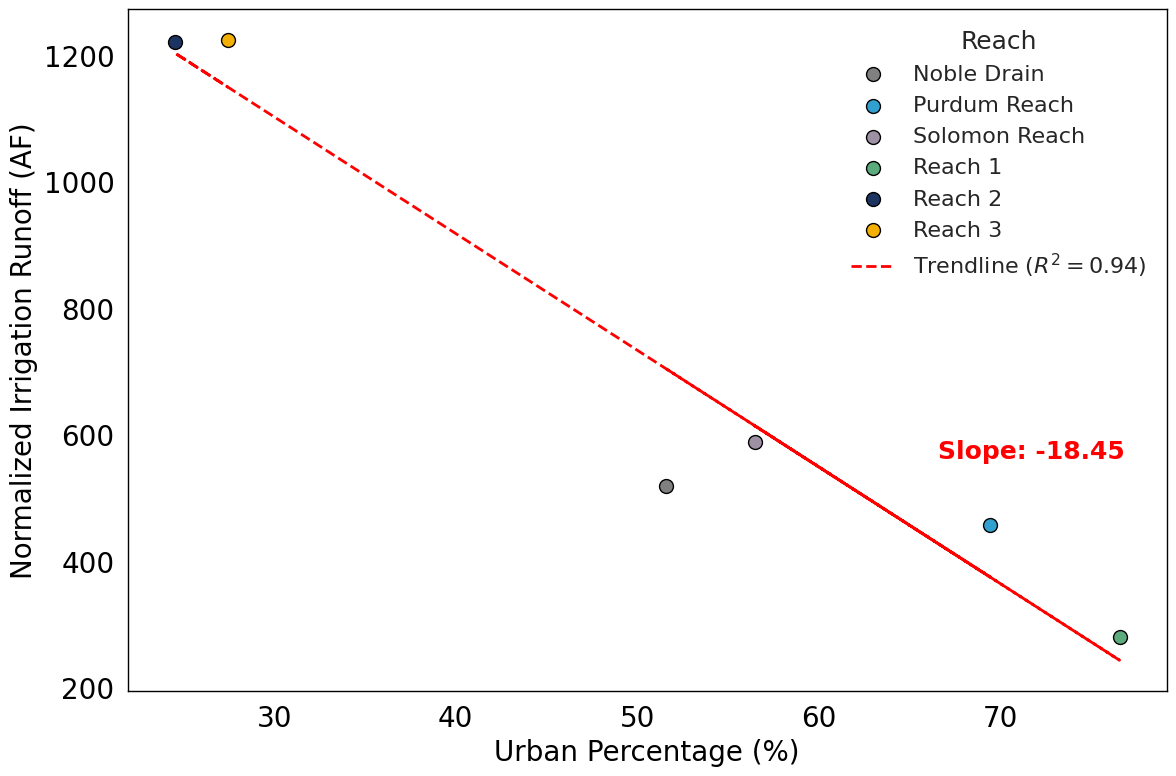

In [40]:
# Scatter plot with Reach palette and trendline
plt.figure(figsize=(12, 8))

# Scatter points for each reach with custom colors from reach_palette
for reach in final_merged['Reach'].unique():
    subset = final_merged[final_merged['Reach'] == reach]
    plt.scatter(
        subset['Urban Percent'],
        subset['normalized_runoff(af)'],
        label=reach,
        color=reach_palette.get(reach, 'grey'),  # Default to grey if reach not in palette
        s=100,
        alpha=1,
        edgecolor='black'
    )

# Fit and plot a trendline for all data
x = final_merged['Urban Percent']
y = final_merged['normalized_runoff(af)']
slope, intercept, r_value, _, _ = linregress(x, y)
trendline = slope * x + intercept

plt.plot(
    x,
    trendline,
    color='red',
    linestyle='--',
    linewidth=2,
    label = rf"Trendline ($R^2={r_value**2:.2f}$)"
)

# Add slope text to the figure
plt.text(
    x.max() - 10,  # Position near the end of the plot
    y.min() + (y.max() - y.min()) * 0.3,  # Position 10% above the min y-value
    f'Slope: {slope:.2f}',
    color='red',
    fontsize=18,
    fontweight='bold'
)


plt.xlabel('Urban Percentage (%)', fontsize=20)
plt.ylabel('Normalized Irrigation Runoff (AF)', fontsize=20)
plt.title('', fontsize=20)
ax = plt.gca()
theme_cust(ax)
ax.tick_params(axis='both', labelsize=20)
plt.legend(title='Reach', fontsize=16, title_fontsize=18, frameon=False)
plt.tight_layout()
plt.show()

## Regression Plot of Water Budget dQ by Runoff & Groundwater estimates

Reaches in final plot: ['Noble Reach' 'Purdum Reach' 'Reach 1' 'Reach 2' 'Reach 3'
 'Solomon Reach']


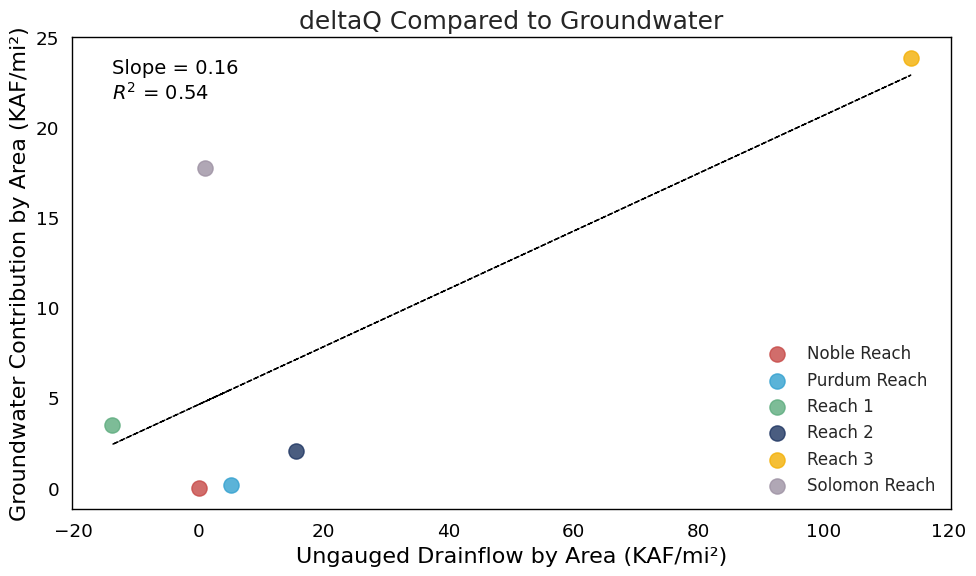

In [84]:
# ----------------------------- #
# Groundwater Contribution X delta Q
# ----------------------------- #

# Load the water budget data
file1 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget.csv')
file2 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv')
reach_area = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv')

# Convert to KAF
file1['GW (KAF)'] = -file1['GW (AF)'] / 1000  # Invert GW values
file2['Residual (KAF)'] = file2['Residual (AF)'] / 1000

# Sum monthly Residual + GW data for each reach
merged = pd.merge(file1[['Reach', 'GW (KAF)']], file2[['Reach', 'Residual (KAF)']],
                  on=['Reach'], how='inner')

summed_data = merged.groupby("Reach", as_index=False).sum()

# Merge with reach area data
summed_data = pd.merge(summed_data, reach_area, on="Reach", how="left")

# Normalize by dividing by area (KAF / square miles)
summed_data['Normalized Residual (KAF/mi²)'] = summed_data['Residual (KAF)'] / summed_data['Area of Reach (mi²)']
summed_data['Normalized GW (KAF/mi²)'] = summed_data['GW (KAF)'] / summed_data['Area of Reach (mi²)']

# Drop NaN and Inf values before regression
summed_data.replace([np.inf, -np.inf], np.nan, inplace=True)
summed_data.fillna(0, inplace=True)  # Ensure missing values are not removed

# Debugging: Check if Noble Drain is included
print("Reaches in final plot:", summed_data['Reach'].unique())

# Check if there are at least two unique values for regression
if summed_data['Normalized Residual (KAF/mi²)'].nunique() > 1:
    # Perform regression
    slope, intercept, r_value, _, _ = linregress(summed_data['Normalized Residual (KAF/mi²)'],
                                                 summed_data['Normalized GW (KAF/mi²)'])
    trendline = slope * summed_data['Normalized Residual (KAF/mi²)'] + intercept
    r_squared = r_value ** 2
else:
    print("Skipping regression: Not enough unique data points")
    slope, intercept, r_squared = None, None, None

# Plot normalized values
plt.figure(figsize=(10, 6))

# Scatter plot with normalized values
for reach in summed_data['Reach']:
    subset = summed_data[summed_data['Reach'] == reach]
    x = subset['Normalized Residual (KAF/mi²)']
    y = subset['Normalized GW (KAF/mi²)']

    plt.scatter(x, y, label=reach, color=reach_palette.get(reach, "black"), s=120, alpha=0.8)

if slope is not None:
    plt.plot(summed_data['Normalized Residual (KAF/mi²)'], trendline, color="black", linestyle="--", linewidth=1)
    annotation_text = f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}"
    plt.text(summed_data['Normalized Residual (KAF/mi²)'].min(),
             summed_data['Normalized GW (KAF/mi²)'].max(),
             annotation_text, fontsize=14, color="black", verticalalignment='top')

# Labels and title
plt.xlabel("Ungauged Drainflow by Area (KAF/mi²)", fontsize=16)
plt.ylabel("Groundwater Contribution by Area (KAF/mi²)", fontsize=16)
plt.title("deltaQ Compared to Groundwater", fontsize=18)

# Customize legend
plt.legend(title="", fontsize=12, title_fontsize=14, frameon=False)

# Apply custom theme
ax = plt.gca()
theme_cust(ax)

# Final layout
plt.tight_layout()
plt.show()

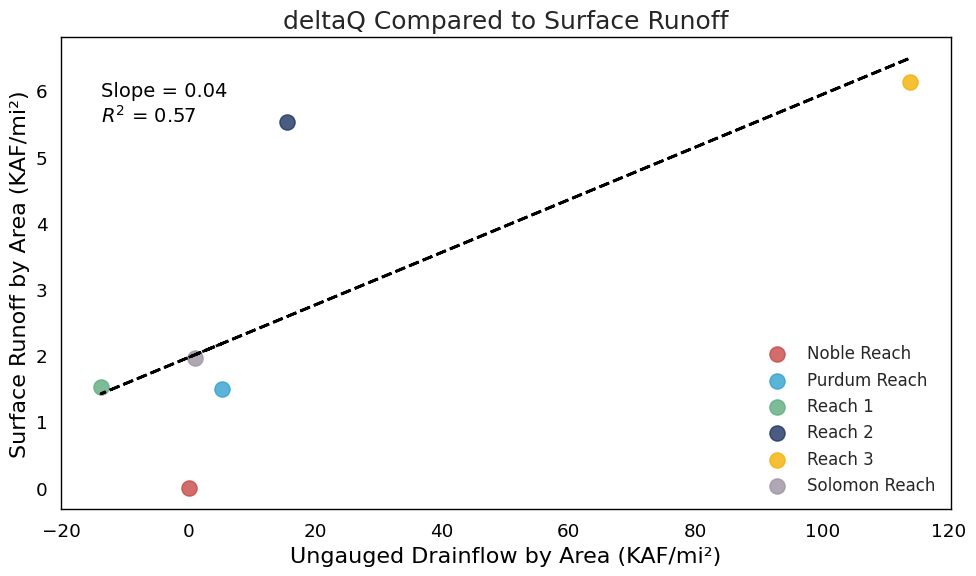

In [85]:
# ----------------------------- #
# Runoff Contribution X delta Q
# ----------------------------- #

# Load the water budget data
file1 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget.csv')
file2 = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv')
reach_area = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv')

# Convert to KAF
file1['SR (KAF)'] = file1['SR (AF)'] / 1000  # Convert Surface Runoff to KAF
file2['Residual (KAF)'] = file2['Residual (AF)'] / 1000  # Convert Residual to KAF

# Merge datasets on Reach and sum values so that each reach has only one point
merged = pd.merge(file1[['Reach', 'SR (KAF)']], file2[['Reach', 'Residual (KAF)']],
                  on=['Reach'], how='inner')

summed_data = merged.groupby("Reach", as_index=False).sum()

# Merge with reach area data
summed_data = pd.merge(summed_data, reach_area, on="Reach", how="left")

# Normalize by dividing by area (KAF / square miles)
summed_data['Normalized Residual (KAF/mi²)'] = summed_data['Residual (KAF)'] / summed_data['Area of Reach (mi²)']
summed_data['Normalized SR (KAF/mi²)'] = summed_data['SR (KAF)'] / summed_data['Area of Reach (mi²)']

# Drop NaN and Inf values before regression
summed_data.replace([np.inf, -np.inf], np.nan, inplace=True)
summed_data.fillna(0, inplace=True)  # Ensure missing values are not removed

# Check if there are at least two unique values for regression
if summed_data['Normalized Residual (KAF/mi²)'].nunique() > 1:
    slope, intercept, r_value, _, _ = linregress(summed_data['Normalized Residual (KAF/mi²)'],
                                                 summed_data['Normalized SR (KAF/mi²)'])
    trendline = slope * summed_data['Normalized Residual (KAF/mi²)'] + intercept
    r_squared = r_value ** 2
else:
    print("Skipping regression: Not enough unique data points")
    slope, intercept, r_squared = None, None, None

# Plot normalized values
plt.figure(figsize=(10, 6))
for reach in summed_data['Reach']:
    subset = summed_data[summed_data['Reach'] == reach]
    x = subset['Normalized Residual (KAF/mi²)']
    y = subset['Normalized SR (KAF/mi²)']

    plt.scatter(x, y, label=reach, color=reach_palette.get(reach, "black"), s=120, alpha=0.8)

# Plot regression, r^2, and slope
if slope is not None:
    plt.plot(summed_data['Normalized Residual (KAF/mi²)'], trendline, color="black", linestyle="--", linewidth=2)
    annotation_text = f"Slope = {slope:.2f}\n$R^2$ = {r_squared:.2f}"
    plt.text(summed_data['Normalized Residual (KAF/mi²)'].min(),
             summed_data['Normalized SR (KAF/mi²)'].max(),
             annotation_text, fontsize=14, color="black", verticalalignment='top')

# Labels and title
plt.xlabel("Ungauged Drainflow by Area (KAF/mi²)", fontsize=16)
plt.ylabel("Surface Runoff by Area (KAF/mi²)", fontsize=16)
plt.title("deltaQ Compared to Surface Runoff", fontsize=18)
plt.legend(title="", fontsize=12, title_fontsize=14, frameon=False)
ax = plt.gca()
theme_cust(ax)
plt.tight_layout()
plt.show()